# Tweet Sentiment Classification

In this project I present a simple model to classify tweets according to their sentiment: positive or negative.

This notebook will serve as a laboratory to design, build, and test the system

----------------------

To avoid repeated code and reduce errors, I will create some classes and functions to handle all stages, from data preprocessing to model evaluation. Later, we can reuse these objects in future projects by changing the corresponding implementation. The goal is to design a simple, reusable, standard interface for any NLP task.

With this idea in mind, let's think carefully about the neccesary components that any NLP task requires. 
- A component to handle the cleaning and preprocessing of the input strings of text that we want to model.
- A component to convert text into a suitable numerical representation for the task at hand. Also called word embeddings.
  - This involves several intermediate steps such as generating a vocabulary
  - Sometimes, we might want to learn these numerical representations from data or use pre-trained embeddings.
- A component to construct a Dataset object that splits data into a train, validation, and test sets (handy while working with PyTorch library).
- A component to generate mini-batches for model training.
- A component to handle model training. Here we can incorporate a way to measure the progress. 
- A component for model evaluation. We also need to track performance metrics for model selection
- A component to make predictions on new(unseen) data.

Note that some of these components will function as subcomponents of other components. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from collections import Counter
from itertools import chain
from argparse import Namespace

import pandas as pd
import numpy as np

import nltk
import os
import re
import string

In [2]:
def set_seed(seed, cuda=False):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

In [11]:
seed=42
#set_seed(seed)

In [3]:
# Let's take a look at the dataset
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## Data preprocessing

In this project I will only work with the text and target column.
In the first component I need to perform some preprocessing steps such as converting to lowercase and removing numbers . To do this, we can define some functions.

In [6]:
def preprocess_string(text_string):
    """
    Converts text string to lowercase and removes punctation.

    Args:
    text_string (str): text string to process.
    
    Returns:
    text_string (str): processed text string.
    """
    text_string = text_string.lower()
    text_string = re.sub(r'[!"#@$%&\'()*+,-./:;<=>?\[\]^_`{|}~]', 
                         r"", text_string)
    text_string = re.sub(r'\b\d+\b', r"", text_string)
    text_string = re.sub(r'  ', r" ", text_string)
    
    return text_string

In [7]:
# We remove # and @ symbols
preprocess_string("Hello, love the earth!! Code 10v3 1234 #love @earth")

'hello love the earth code 10v3 love earth'

We can use the .apply method to process each row in the dataset

In [8]:
train_df.text = train_df.text.apply(preprocess_string)
test_df.text = test_df.text.apply(preprocess_string)

In [9]:
test_df.text

0                      just happened a terrible car crash
1       heard about earthquake is different cities sta...
2       there is a forest fire at spot pond geese are ...
3                   apocalypse lighting spokane wildfires
4              typhoon soudelor kills in china and taiwan
                              ...                        
3258    earthquake safety los angeles ûò safety faste...
3259    storm in ri worse than last hurricane my citya...
3260    green line derailment in chicago httptcoutbxlc...
3261    meg issues hazardous weather outlook hwo httpt...
3262    cityofcalgary has activated its municipal emer...
Name: text, Length: 3263, dtype: object

In [12]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val= train_test_split(train_df.drop(['target'], axis=1), 
                                                 train_df.target, 
                                                 test_size=0.20, 
                                                 stratify=train_df.target, 
                                                 random_state=seed)

In [13]:
X_train = X_train.join(y_train)
X_val = X_val.join(y_val)

## Classes and functions

In [14]:
class Vocabulary():
    def __init__(self, tokens):
        self.tokens = tokens

    @classmethod
    def fromDataframe(cls, dataframe, cutoff=30):
        counts = Counter([word for text in dataframe.text \
                          for word in text.split(" ")])
        tokens = ["unk"]
        for token, count in counts.items():
            if count >= cutoff:
                tokens.append(token)

        return cls(tokens)
            

class Vectorizer():
    """
    Class to convert text strings into a numerical representation
    """
    def __init__(self, vocabulary, dataframe):
        self.vocabulary = vocabulary
        
        def my_tokenizer(text):
            tokens = text.split(" ")
            tokens = [token if token in self.vocabulary.tokens else "unk" for token in tokens]
            return tokens
        
        self.tfidf = TfidfVectorizer(tokenizer=my_tokenizer, 
                                     vocabulary=vocabulary.tokens, 
                                     token_pattern=None)
        self.tfidf.fit(dataframe.text)
    
    def vectorize(self, row):
        text = self.tfidf.transform([row]).toarray().reshape(-1)
        return text
        
        
    @classmethod
    def fromDataframe(cls, dataframe, cutoff=30):
        vocabulary = Vocabulary.fromDataframe(dataframe, cutoff=cutoff)
        return cls(vocabulary, dataframe)


class CustomDataset(Dataset):
    """
    Class to handle vectorization and construction of the vocabulary
    """
    def __init__(self, vectorizer, train_df, test_df):
        """
        Args:
        dataframe (pandas.Dataframe): dataframe containing data 
            (must include a "text" and "target" columns)
        vectorizer (Vectorizer): a vectorizer instantiated from dataset
        """
        self.split = "train"

        self.train_df = train_df
        self.test_df = test_df
        self.set_split(self.split)
        
        self.vectorizer = vectorizer
        self.vocabulary = vectorizer.vocabulary.tokens

    @classmethod
    def fromDataframe(cls, train_df, test_df, cutoff=30):
        vectorizer = Vectorizer.fromDataframe(train_df, cutoff=cutoff)
        return cls(vectorizer, train_df, test_df)

    def __len__(self):
        """
        Returns the number of sample in the dataset.
        """
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Loads and returns a sample from the dataset at the given index.
        """
        text = self.dataframe.iloc[idx].text
        text = self.vectorizer.vectorize(text)

        label = self.dataframe.iloc[idx].target
        return text, label

    def getVectorizer(self):
        return self.vectorizer

    def getVocabulary(self):
        return self.vocabulary

    def set_split(self, split):
        if split == "train":
            self.dataframe = self.train_df
        else:
            self.dataframe = self.test_df

In [160]:
class Classifier(nn.Module):
    """Classifier based on simple feed-forward neural network."""
    def __init__(self, n_features):
        super(Classifier, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(in_features=n_features, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=1),
        )
        
    def forward(self, x):
        x = self.features(x).squeeze()
        return x

In [56]:
def train(model, dataloader, loss_func, optimizer, args, train_state):
    """
    Runs a traning epoch
    Args:
    
    """

    dataset_size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # set classifier to train mode
    model.train()

    # set loss and accuracy metrics to 0
    running_loss = 0
    running_acc = 0

    for batch, (X, y) in enumerate(dataloader):

        X = X.to(args.device)
        y = y.to(args.device)
        #------------------
        # set gradient to zero
        optimizer.zero_grad()
    
        # compute model predictions and loss
        y_pred = classifier(X.float())
        loss = loss_func(y_pred, y.float())

        # Apply backpropagation
        loss.backward()

        # update model parameters
        optimizer.step()

        # statistics
        running_loss += loss.item() * X.size(0)
        running_acc += compute_accuracy(y_pred, y)

        print_info(loss, batch, X, dataset_size)
        
    print(f"Train Error: \n Accuracy: {(100*running_acc/dataset_size):>0.1f}%")
    train_state['train_loss'].append(running_loss / num_batches)
    train_state['train_acc'].append(running_acc / dataset_size)
        

def validation(model, dataloader, loss_func, optimizer, args, train_state):
    """
    Runs a traning epoch
    Args:
    
    """

    dataset_size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # set classifier to train mode
    model.eval()

    # set loss and accuracy metrics to 0
    running_loss = 0
    running_acc = 0

    with torch.no_grad():
        for X, y in dataloader:
    
            X = X.to(args.device)
            y = y.to(args.device)
            #------------------
        
            # compute model predictions and loss
            y_pred = classifier(X.float())
            loss = loss_func(y_pred, y.float())

            # statistics
            running_loss += loss.item() * X.size(0)
            running_acc += compute_accuracy(y_pred, y)
        
    print(f"Test Error: \n Accuracy: {(100*running_acc/dataset_size):>0.1f}%, Avg loss: {running_loss / num_batches:>8f} \n")    

    train_state['val_loss'].append(running_loss / num_batches)
    train_state['val_acc'].append(running_acc / dataset_size)

In [161]:
args = Namespace(
    # Data info
    cutoff = 10,
    vocab_size = 0,
    # Model hyperparameters
    learning_rate = 0.001,
    weight_decay=0.001,
    batchsize = 32,
    epochs = 30,
    early_stopping_criteria = 10,
    # runtime 
    device = 'cpu',
    model_state_file = 'model.pth',
    min_val_loss = float('inf')
)

def build_state(args):
    """
    Returns dictionary 
    """
    state = {'current_ epoch':0,
             'stop_early': False,
             'early_stopping_step':0,
             'current_min_val_loss': args.min_val_loss,
             'learning_rate': args.learning_rate,
             'train_loss': [],
             'train_acc': [],
             'val_loss':[],
             'val_acc':[],
             'test_loss':-1,
             'test_acc':-1,
             'model_filename':args.model_state_file
            }
    return state

def update_state(state, model, args, tolerance=0):
    """
    Changes train state according to validation loss values

    Args:
        state: train state dictionary
        model: model that is being trained
        args: namespace with important variables
    """
    if state['current_epoch'] == 0:
        torch.save(model.state_dict(), state['model_filename'])
        state['stop_early'] = False

    elif state['current_epoch'] >= 1:
        current_loss =  state['val_loss'][-1]

        if current_loss < state['current_min_val_loss']:
            state['current_min_val_loss'] = current_loss
            state['early_stopping_step'] = 0
            torch.save(model.state_dict(), state['model_filename'])
            
        elif current_loss >= state['current_min_val_loss'] + tolerance:
            state['early_stopping_step'] += 1
            
        
    return state

def compute_accuracy(y_pred, y_true, thresh=0.5):
    """
    Computes accuracy from predicted and true labels
    """
    y_true = y_true.cpu()
    y_pred = (torch.sigmoid(y_pred)> thresh).cpu().long()
    n_correct =  torch.eq(y_pred, y_true).sum().item()
    return n_correct

def print_info(loss, batch, X, size):
    if batch % 10 == 0:
        current = (batch + 1) * len(X)
        print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

## Training

In [162]:
# Instantiate dataset and vocabulary
reviewDataset = CustomDataset.fromDataframe(X_train, X_val, cutoff=args.cutoff)
vocabulary = reviewDataset.getVocabulary()

args.vocab_size = len(vocabulary) 

# Instantiate classfier
classifier = Classifier(n_features=args.vocab_size)

#Instantiate loss and optimizer
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

# Optional: Instantiate learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

# Create state to keep track of training steps

train_state = build_state(args)

In [163]:
# Model training
args.epochs = 60

for epoch in range(args.epochs):
    train_state['current_epoch'] = epoch
    # set classifier to train mode
    reviewDataset.set_split("train")
    dataloader = DataLoader(reviewDataset, batch_size=args.batchsize, shuffle=True)
    train(classifier, dataloader, loss_func, optimizer, args, train_state)

    # set classifier to eval mode
    reviewDataset.set_split("eval")
    dataloader = DataLoader(reviewDataset, batch_size=args.batchsize, shuffle=True)
    validation(classifier, dataloader, loss_func, optimizer, args, train_state)

    train_state = update_state(train_state, classifier, args)
    
    scheduler.step(train_state['val_loss'][-1])

    if train_state['early_stopping_step'] >= args.early_stopping_criteria:
        print("Early Stopping Criteria Satisfied")
        break

loss: 0.683199  [   32/ 6090]
loss: 0.677202  [  352/ 6090]
loss: 0.682267  [  672/ 6090]
loss: 0.675700  [  992/ 6090]
loss: 0.681469  [ 1312/ 6090]
loss: 0.707234  [ 1632/ 6090]
loss: 0.680684  [ 1952/ 6090]
loss: 0.635997  [ 2272/ 6090]
loss: 0.654440  [ 2592/ 6090]
loss: 0.673907  [ 2912/ 6090]
loss: 0.603107  [ 3232/ 6090]
loss: 0.619736  [ 3552/ 6090]
loss: 0.642313  [ 3872/ 6090]
loss: 0.602493  [ 4192/ 6090]
loss: 0.622311  [ 4512/ 6090]
loss: 0.674836  [ 4832/ 6090]
loss: 0.579679  [ 5152/ 6090]
loss: 0.626063  [ 5472/ 6090]
loss: 0.600114  [ 5792/ 6090]
loss: 0.538271  [ 1910/ 6090]
Train Error: 
 Accuracy: 64.4%
Test Error: 
 Accuracy: 77.7%, Avg loss: 18.017046 

loss: 0.529611  [   32/ 6090]
loss: 0.553054  [  352/ 6090]
loss: 0.537520  [  672/ 6090]
loss: 0.495179  [  992/ 6090]
loss: 0.517222  [ 1312/ 6090]
loss: 0.539283  [ 1632/ 6090]
loss: 0.483754  [ 1952/ 6090]
loss: 0.545921  [ 2272/ 6090]
loss: 0.563728  [ 2592/ 6090]
loss: 0.506735  [ 2912/ 6090]
loss: 0.561398  

## Metrics plots

In [137]:
import matplotlib.pyplot as plt

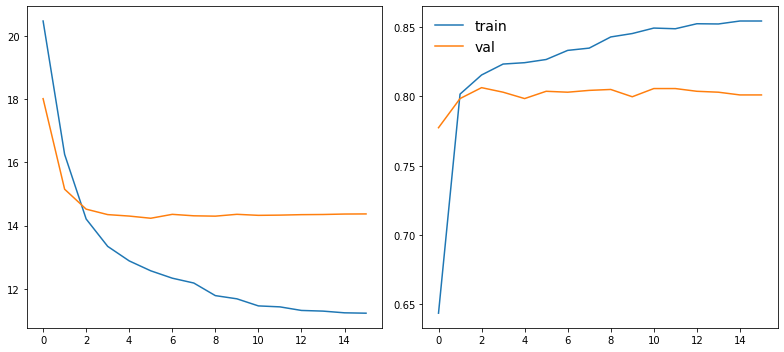

In [164]:
fig, ax = plt.subplots(1,2,figsize=(11,5))

ax[0].plot(train_state['train_loss'], label='train')
ax[0].plot(train_state['val_loss'], label='val')

ax[1].plot(train_state['train_acc'], label='train')
ax[1].plot(train_state['val_acc'], label='val')

plt.legend(fontsize=14, frameon=False)

plt.tight_layout()
plt.show()

## Predictions

In [165]:
vectorizer = reviewDataset.getVectorizer()

In [166]:
test_df

,id,keyword,location,text,target
0,0,NaN,NaN,just happened a terrible car crash,1
1,2,NaN,NaN,heard about earthquake is different cities sta...,1
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...,1
3,9,NaN,NaN,apocalypse lighting spokane wildfires,1
4,11,NaN,NaN,typhoon soudelor kills in china and taiwan,1
...,...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles ûò safety faste...,1
3259,10865,NaN,NaN,storm in ri worse than last hurricane my citya...,1
3260,10868,NaN,NaN,green line derailment in chicago httptcoutbxlc...,1
3261,10874,NaN,NaN,meg issues hazardous weather outlook hwo httpt...,1


In [167]:
def predict_sentiment(review, classifier, vectorizer):
    """
    Predicts sentiment of review
    Args:
        review (str): a review string 
        classifier : model to make predictions
        vectorizer (Vectorizer): vectorizer to convert review string into a numerical representation
    
    returns:
        probability of sentiment being negative
    """
    X = vectorizer.vectorize(review)
    X = torch.tensor(X).view(1,-1).float()
    prediction = classifier(X)

    return torch.sigmoid(prediction).item()

In [168]:
predict_sentiment(test_df.iloc[4].text, classifier, vectorizer)

0.975396990776062

In [169]:
test_df['target'] = test_df['text'].apply(predict_sentiment, args=(classifier, vectorizer))

In [170]:
test_df['target'] = (test_df['target'] >= 0.5).astype(int)

In [171]:
test_df

,id,keyword,location,text,target
0,0,NaN,NaN,just happened a terrible car crash,1
1,2,NaN,NaN,heard about earthquake is different cities sta...,1
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...,1
3,9,NaN,NaN,apocalypse lighting spokane wildfires,1
4,11,NaN,NaN,typhoon soudelor kills in china and taiwan,1
...,...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles ûò safety faste...,1
3259,10865,NaN,NaN,storm in ri worse than last hurricane my citya...,1
3260,10868,NaN,NaN,green line derailment in chicago httptcoutbxlc...,1
3261,10874,NaN,NaN,meg issues hazardous weather outlook hwo httpt...,1


In [177]:
test_df.to_csv('data/submission2.csv', columns=['id', 'target'], index=False)

## Tests

In [31]:
myDataset = CustomDataset.fromDataframe(X_train, X_val, cutoff=10)

In [174]:
probs = X_val.text.apply(predict_sentiment, args=(classifier, vectorizer))

In [175]:
accs = []
truth = X_val.target.values
for thresh in [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    preds = (probs >= thresh).astype(int)
    accs.append(np.sum(preds==truth)/len(truth))

In [176]:
accs

[0.7314510833880499,
 0.7524622455679579,
 0.7734734077478661,
 0.7826657912015759,
 0.8010505581089954,
 0.8108995403808273,
 0.8115561391989494,
 0.8095863427445831,
 0.7964543663821405,
 0.7806959947472094]

In [114]:
X_train.target.value_counts(normalize=True)

target
0    0.570279
1    0.429721
Name: proportion, dtype: float64

In [55]:
len(myDataset.getVocabulary())

843

In [75]:
myDataset.set_split("train")

In [77]:
myloader = DataLoader(myDataset, batch_size=32, shuffle=True)

In [78]:
mybatch = next(iter(myloader))

In [82]:
mybatch[0].shape

torch.Size([32, 1, 843])

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [10]:
vocabulary = ["hello", "world", "unk"]

def my_tokenizer(text):
    tokens = text.split(" ")
    tokens = [token if token in vocabulary else "unk" for token in tokens]
    return tokens

In [24]:
tfidf = TfidfVectorizer(tokenizer=my_tokenizer, vocabulary=vocabulary, token_pattern=None)

In [28]:
X = tfidf.fit_transform(["hello world daddy", "hello my little pony", "hehe gimme a kiss"])

In [29]:
tfidf.vocabulary_

{'hello': 0, 'world': 1, 'unk': 2}

In [30]:
X.toarray()

array([[0.54783215, 0.72033345, 0.42544054],
       [0.39442846, 0.        , 0.91892665],
       [0.        , 0.        , 1.        ]])

In [48]:
counts = Counter([word for text in df.text for word in text.split(" ")])

In [49]:
import matplotlib.pyplot as plt

(array([0.0000e+00, 2.3425e+04, 3.3000e+03, 1.4420e+03, 8.2800e+02,
        5.0700e+02, 3.4900e+02, 2.5900e+02, 2.0500e+02, 1.5900e+02,
        1.4700e+02, 1.1000e+02, 1.0400e+02, 8.8000e+01, 7.7000e+01,
        6.4000e+01, 7.0000e+01, 6.7000e+01, 5.7000e+01, 4.7000e+01,
        3.4000e+01, 3.5000e+01, 3.1000e+01, 3.5000e+01, 4.1000e+01,
        3.7000e+01, 2.0000e+01, 2.9000e+01, 2.6000e+01, 1.9000e+01,
        2.7000e+01, 1.8000e+01, 1.7000e+01, 1.6000e+01, 7.0000e+00,
        1.0000e+01, 1.7000e+01, 1.5000e+01, 8.0000e+00, 1.0000e+01,
        7.0000e+00, 5.0000e+00, 9.0000e+00, 7.0000e+00, 6.0000e+00,
        2.0000e+00, 4.0000e+00, 4.0000e+00, 7.0000e+00, 2.0000e+00,
        7.0000e+00, 2.0000e+00, 5.0000e+00, 2.0000e+00, 4.0000e+00,
        1.1000e+01, 9.0000e+00, 3.0000e+00, 4.0000e+00, 3.0000e+00,
        4.0000e+00, 5.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00,
        2.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00, 5.0000e+00,
        4.0000e+00, 3.0000e+00, 3.0000e+00, 2.00

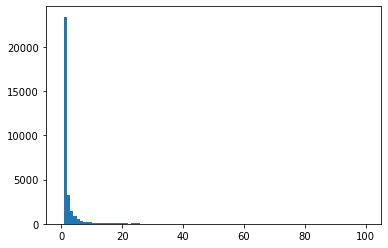

In [55]:
plt.hist(list(counts.values()), range=(0,100), bins=100)

In [83]:
np.array([1,2,3]).shape

(3,)

In [86]:
np.zeros(10).shape

(10,)